In [296]:
from scipy.signal import welch
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]



In [357]:

def sim_run(G_VAL, LR, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G_VAL: float, global coupling
    LR: array, learning rate (Homogeneous or heterogenos. Decay will be calcualted for each region with this)
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates
    rates_inh_dyn: np.array, dynamic of inhibitory rates
    bold_dyn: np.array, dynamic of BOLD signal
    fic_t_dyn: np.array, dynamic of FIC

    """
    
    params = dmf.default_params(C=C)
    fit_res = np.load("./data/fit_res_3-44.npy")
    b = fit_res[0] # First element is the slope
    a = fit_res[1]
    params['G'] = G_VAL
    params['seed'] = SEED
    params['obj_rate'] = 3.44
    DECAY = np.exp(a+np.log(LR)*b)    
    params['lr_vector'] = LR
    params['taoj_vector'] =  DECAY
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params["with_decay"] = True
    params["with_plasticity"] = True
    params['return_bold'] = False
    params["return_fic"] = True
    params["return_rate"] = True
    rates_dyn, rates_inh_dyn, _, fic_t_dyn = dmf.run(params, NB_STEPS)
    return rates_dyn, rates_inh_dyn, fic_t_dyn

def sim_run_notplastic(G_VAL, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G_VAL: float, global coupling
    LR: array, learning rate (Homogeneous or heterogenos. Decay will be calcualted for each region with this)
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates
    rates_inh_dyn: np.array, dynamic of inhibitory rates
    bold_dyn: np.array, dynamic of BOLD signal
    fic_t_dyn: np.array, dynamic of FIC

    """
    
    params = dmf.default_params(C=C)
    fit_res = np.load("./data/fit_res_3-44.npy")
    b = fit_res[0] # First element is the slope
    a = fit_res[1]
    params['G'] = G_VAL
    params['seed'] = SEED
    params['obj_rate'] = 3.44    
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params["with_decay"] = False
    params["with_plasticity"] = False
    params['return_bold'] = False
    params["return_fic"] = True
    params["return_rate"] = True
    rates_dyn, rates_inh_dyn, _, fic_t_dyn = dmf.run(params, NB_STEPS)
    return rates_dyn, rates_inh_dyn, fic_t_dyn

import numpy as np

def vectorize_along_axis(axis=0):
    def decorator(func):
        def wrapper(data, *args, **kwargs):
            # if the data is 1D, just call the function directly
            if data.ndim == 1:
                return func(data, *args, **kwargs)
            # otherwise, apply the function along the specified axis
            return np.apply_along_axis(func, axis, data, *args, **kwargs)
        return wrapper
    return decorator

@vectorize_along_axis(axis=0)
def get_autcorr(rates):
    """Get the autocorrelation function from a 1D rates vector."""
    signal = rates - np.mean(rates)
    # Calculate autocorrelation function (full convolution)
    autocorr = np.correlate(signal, signal, mode='full')
    # Normalize: divide by the variance and length of the signal
    autocorr = autocorr / (np.var(signal) * len(signal))
    # Only keep the second half (non-negative lags)
    autocorr = autocorr[len(signal)-1:]
    return autocorr


def get_max_freq_and_power(rates):
    freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:,:100],axis=1)
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:,:100],axis=1)
    return max_freqs, max_power,freqs,psd

## Generate control power distribution

In [309]:
import numpy as np
import os
from joblib import Parallel, delayed

LR_HOMO = 100
LR_HOMO_VEC = np.ones(200)*LR_HOMO
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 5000
NB_STEPS = 30000
G_VAL = 3.5
G_VAL_NOTPLASTIC = 2.1
SEED_BASE = 100

def run_simulation(idx, lr):
    SEED = SEED_BASE + idx
    # Create a homogeneous LR vector for all regions
    LR_VEC = np.ones(N) * lr
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates, _, _ = sim_run(G_VAL, LR_VEC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]

def run_simulation_notplastic(idx):
    SEED = SEED_BASE + idx
    # Create a homogeneous LR vector for all regions
    LR_VEC = np.ones(N)
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates, _, _ = sim_run_notplastic(G_VAL_NOTPLASTIC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]
# Execute 100 simulation runs in parallel.
lr = 10000
simulations = Parallel(n_jobs=32)(delayed(run_simulation)(idx, lr) for idx in range(100))
rates_all_high_lr = np.array(simulations)
save_path = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}_100reps_30ksteps.npy"
np.save(save_path, rates_all_high_lr)
lr = 100
simulations = Parallel(n_jobs=32)(delayed(run_simulation)(idx, lr) for idx in range(100))
rates_all_low_lr = np.array(simulations)
save_path = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}_100reps_30ksteps.npy"
np.save(save_path, rates_all_low_lr)
simulations_notplastic = Parallel(n_jobs=32)(delayed(run_simulation_notplastic)(idx) for idx in range(100))
rates_all_notplastic = np.array(simulations_notplastic)
save_path = f"./Results/homogeneous/g_{G_VAL_NOTPLASTIC}_notplastic_100reps_30ksteps.npy"
np.save(save_path, rates_all_notplastic)

# Ensure the output directory exists
#os.makedirs("./Results/homogeneous", exist_ok=True)
#filename = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}.npy"
#np.save(filename, rates_all)
#print(f"Saved homogeneous simulation results for LR = {lr} to {filename}")

In [312]:
NB_STEPS = 15000

In [313]:
r = run_simulation_notplastic(0)
print(r.shape)

(200, 10000)


In [314]:
lr = 10000
simulations = Parallel(n_jobs=32)(delayed(run_simulation)(idx, lr) for idx in range(100))
rates_all_high_lr = np.array(simulations)
save_path = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}_100reps_15ksteps.npy"
np.save(save_path, rates_all_high_lr)
lr = 100
simulations = Parallel(n_jobs=32)(delayed(run_simulation)(idx, lr) for idx in range(100))
rates_all_low_lr = np.array(simulations)
save_path = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}_100reps_15ksteps.npy"
np.save(save_path, rates_all_low_lr)
simulations_notplastic = Parallel(n_jobs=32)(delayed(run_simulation_notplastic)(idx) for idx in range(100))
rates_all_notplastic = np.array(simulations_notplastic)
save_path = f"./Results/homogeneous/g_{G_VAL_NOTPLASTIC}_notplastic_100reps_15ksteps.npy"
np.save(save_path, rates_all_notplastic)

In [358]:
# Load the 15k steps results
rates_all_low_lr = np.load(f"./Results/homogeneous/g_{G_VAL}_lr_100_100reps_15ksteps.npy")
rates_all_high_lr = np.load(f"./Results/homogeneous/g_{G_VAL}_lr_10000_100reps_15ksteps.npy")
rates_all_notplastic = np.load(f"./Results/homogeneous/g_{G_VAL_NOTPLASTIC}_notplastic_100reps_15ksteps.npy")


In [359]:
max_freqs_all_high_lr = []
max_powers_all_high_lr = []
freqs_all_high_lr = []
psd_all_high_lr = []

for rates in rates_all_high_lr:
    max_freqs, max_powers, freqs, psd = get_max_freq_and_power(rates)
    max_freqs_all_high_lr.append(max_freqs)
    max_powers_all_high_lr.append(max_powers)
    freqs_all_high_lr.append(freqs)
    psd_all_high_lr.append(psd)

max_freqs_all_high_lr = np.array(max_freqs_all_high_lr)
max_powers_all_high_lr = np.array(max_powers_all_high_lr)
freqs_all_high_lr = np.array(freqs_all_high_lr)
psd_all_high_lr = np.array(psd_all_high_lr)


max_freqs_all_low_lr = []
max_powers_all_low_lr = []
freqs_all_low_lr = []
psd_all_low_lr = []

for rates in rates_all_low_lr:
    max_freqs, max_powers, freqs, psd = get_max_freq_and_power(rates)
    max_freqs_all_low_lr.append(max_freqs)
    max_powers_all_low_lr.append(max_powers)
    freqs_all_low_lr.append(freqs)
    psd_all_low_lr.append(psd)

max_freqs_all_low_lr = np.array(max_freqs_all_low_lr)
max_powers_all_low_lr = np.array(max_powers_all_low_lr)
freqs_all_low_lr = np.array(freqs_all_low_lr)
psd_all_low_lr = np.array(psd_all_low_lr)


max_freqs_all_notplastic = []
max_powers_all_notplastic = []
freqs_all_notplastic = []
psd_all_notplastic = []

for rates in rates_all_notplastic:
    max_freqs, max_powers, freqs, psd = get_max_freq_and_power(rates)
    max_freqs_all_notplastic.append(max_freqs)
    max_powers_all_notplastic.append(max_powers)
    freqs_all_notplastic.append(freqs)
    psd_all_notplastic.append(psd)

max_freqs_all_notplastic = np.array(max_freqs_all_notplastic)
max_powers_all_notplastic = np.array(max_powers_all_notplastic)
freqs_all_notplastic = np.array(freqs_all_notplastic)
psd_all_notplastic = np.array(psd_all_notplastic)

###

max_powers has NREPSxNREGIONS values representing the maximum power calculated across axis=1 of the psd. Which means that for each region it is looking at which was the frequency (axis=1) that had the highest power.

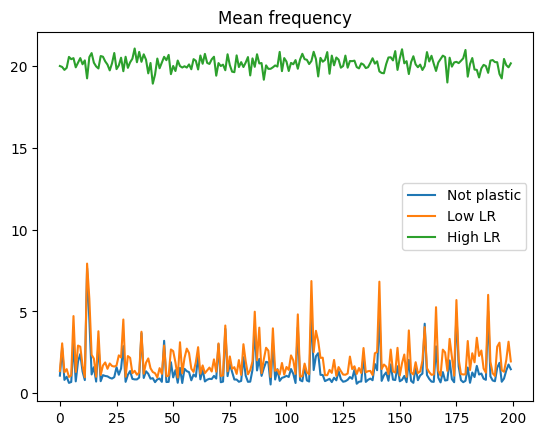

In [374]:
# 
plt.plot(max_freqs_all_notplastic.mean(axis=0))
plt.plot(max_freqs_all_low_lr.mean(axis=0))
plt.plot(max_freqs_all_high_lr.mean(axis=0))
plt.legend(["Not plastic", "Low LR", "High LR"])
plt.title("Mean frequency")
plt.show()

In [382]:
psd_all_notplastic.shape

(100, 200, 2001)

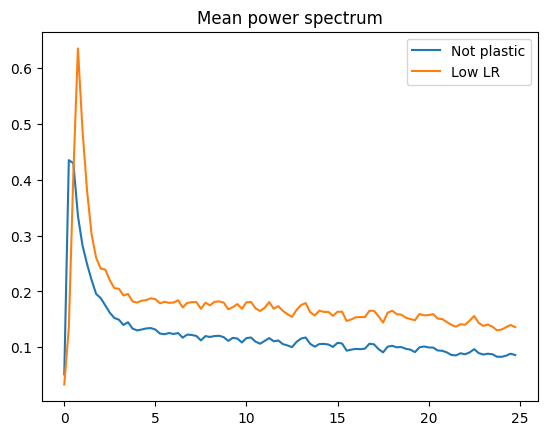

In [384]:
# I compare the power of low frequency between LOW Lr and not plastic
plt.plot(freqs_all_notplastic[0,:100], psd_all_notplastic[0,:,:100].mean(axis=0))
plt.plot(freqs_all_low_lr[0,:100], psd_all_low_lr[0,:,:100].mean(axis=0))
plt.legend(["Not plastic", "Low LR"])
plt.title("Mean power spectrum")
plt.show()

In [387]:
diff_psd.mean(axis=0).shape

(200, 2001)

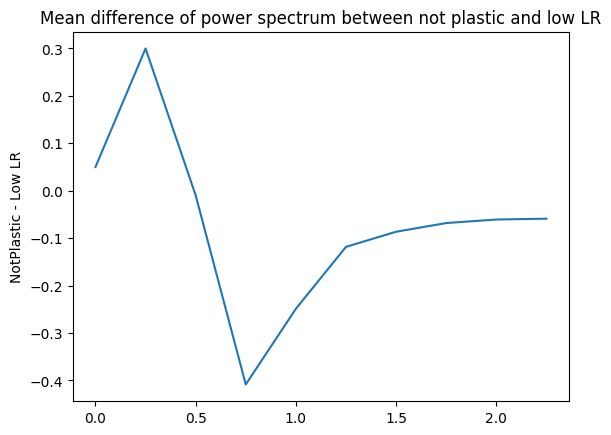

In [390]:
# Do a similar plot but the y axis is the difference accross repetions between not plastic and low lr
# Calculate the differce of power spectrum between not plastic and low lr
# Across all repetitions (axis=0)
diff_psd = psd_all_notplastic - psd_all_low_lr
plt.plot(freqs_all_notplastic[0,:10], diff_psd.mean(axis=0).mean(axis=0)[:10])
plt.title("Mean difference of power spectrum between not plastic and low LR")
plt.ylabel("NotPlastic - Low LR")
plt.show()